In [1]:
import os
import logging
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_community.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnablePassthrough
from langchain.retrievers.multi_query import MultiQueryRetriever
from tavily import TavilyClient
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

In [ ]:
# Tavily api key
TAVILY_API_KEY = "YOUR API"

In [3]:
def create_vector_db(file_path: str) -> Chroma:
    try:
        logger.info(f"Creating vector DB from file path: {file_path}")
        loader = UnstructuredPDFLoader(file_path)
        data = loader.load()
        logger.info(f"Loaded {len(data)} pages from PDF.")

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=100)
        chunks = text_splitter.split_documents(data)
        logger.info(f"Document split into {len(chunks)} chunks.")

        embeddings = OllamaEmbeddings(model="nomic-embed-text", show_progress=True)
        vector_db = Chroma.from_documents(
            documents=chunks,
            embedding=embeddings,
            collection_name="contract_db",
            persist_directory=None
        )
        logger.info("Vector DB created successfully.")
        return vector_db

    except Exception as e:
        logger.error(f"Error creating vector DB: {e}")
        return None
    
def query_knowledge_base(vector_db: Chroma, user_query: str) -> str:
    logger.info(f"Querying knowledge base with: {user_query}")
    llm = ChatOllama(model="granite3-dense:2b", temperature=0)

    retriever = MultiQueryRetriever.from_llm(
        vector_db.as_retriever(),
        llm,
        prompt=ChatPromptTemplate.from_template(
            """Retrieve the most relevant content for the following query: {question}"""
        ),
    )

    query_prompt = ChatPromptTemplate.from_template(
        """Answer the question based ONLY on the following context:
        {context}
        Question: {question}
        If unsure, state that you don't know.
        """
    )

    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | query_prompt
        | llm
        | StrOutputParser()
    )

    try:
        response = chain.invoke(user_query)
        logger.info("Query processed successfully.")
        return response
    except Exception as e:
        logger.error(f"Error processing query: {e}")
        return "Error occurred while processing the query."

In [4]:
def search_web(query: str) -> str:
    try:
        tavily_client = TavilyClient(api_key=TAVILY_API_KEY)
        logger.info(f"Performing web search for query: {query}")
        response = tavily_client.search(query=query)
        results = "\n".join([f"{r['title']}: {r['url']}" for r in response.get("results", [])])
        logger.info("Web search completed successfully.")
        return results
    except Exception as e:
        logger.error(f"Error during web search: {e}")
        return "Error occurred during web search."

In [ ]:
def main():
    file_path = "C:/Users/prana/Downloads/tryryy.pdf"  
    if not os.path.exists(file_path):
        logger.error(f"File not found: {file_path}")
        return

    vector_db = create_vector_db(file_path)
    if not vector_db:
        return

    user_query = input("Enter your query: ")
    doc_result = query_knowledge_base(vector_db, user_query)
    logger.info(f"Document Query Result:\n{doc_result}")

    vector_db.delete_collection()

    web_results = search_web(user_query)
    logger.info(f"Web Search Results:\n{web_results}")

    combined_result = (
        f"Document Query Result:\n{doc_result}\n\n"
        f"Web Search Results:\n{web_results}"
    )
    print(combined_result)

if __name__ == "__main__":
    main()

2025-06-08 13:17:31 - INFO - Creating vector DB from file path: C:/Users/prana/Downloads/tryryy.pdf
2025-06-08 13:17:35 - INFO - NumExpr defaulting to 8 threads.
c:\Users\prana\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-06-08 13:17:52 - INFO - pikepdf C++ to Python logger bridge initialized
2025-06-08 13:17:52 - INFO - Loaded 1 pages from PDF.
2025-06-08 13:17:52 - INFO - Document split into 1 chunks.
C:\Users\prana\AppData\Local\Temp\ipykernel_44252\413932920.py:12: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class

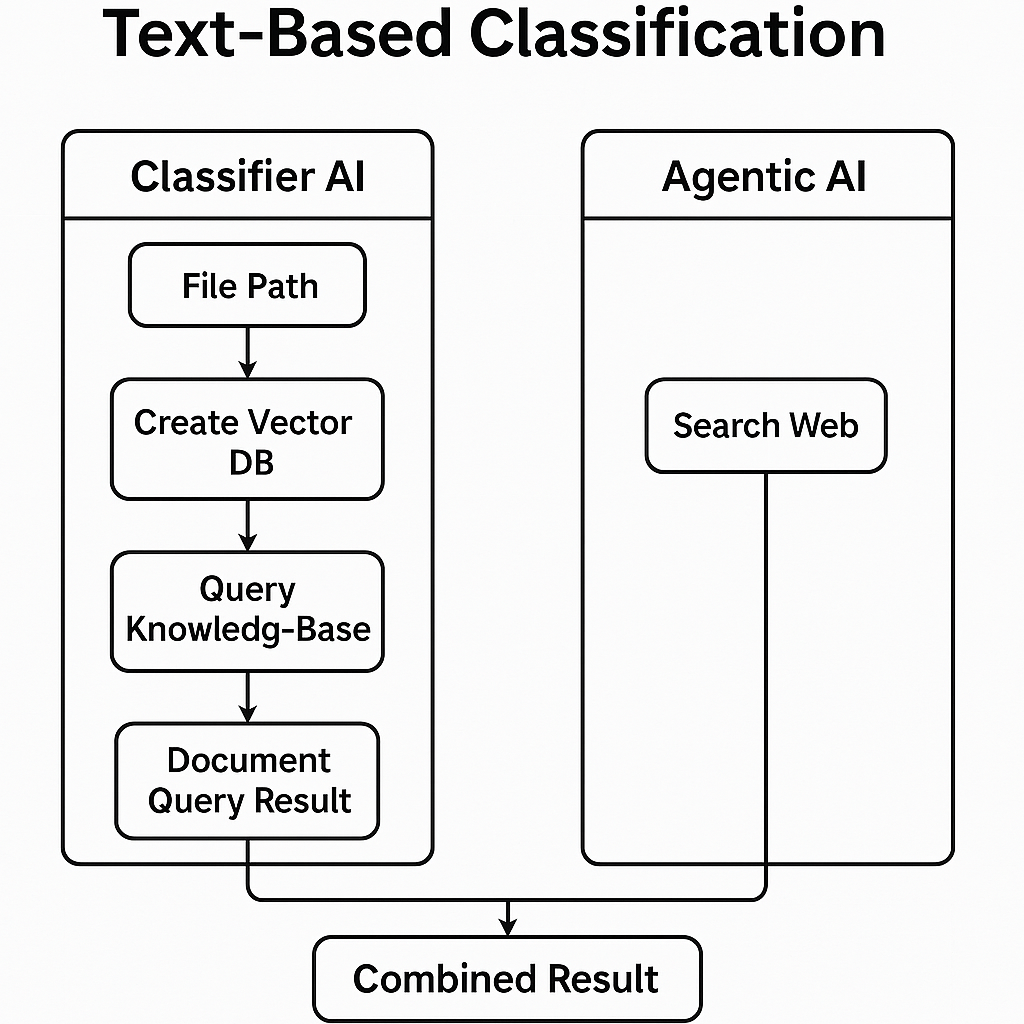

Document Query Result:
Based on the provided context, Narendra Modi is described as the President of Australia and his age is stated to be 53. However, it's important to note that this information might not be accurate as Mr. Modi is actually the Prime Minister of India, not the President of Australia. The age mentioned is also incorrect as Narendra Modi was born on September 17, 1950, making him currently 68 years old.
2025-04-14 10:56:10 - INFO - Performing web search for query: who is narendra modi? and his age ?
2025-04-14 10:56:19 - INFO - Web search completed successfully.
2025-04-14 10:56:19 - INFO - Web Search Results:
Narendra Modi Wiki, Age, Wife, Family, Caste, Biography: https://wikibio.in/narendra-modi/
Narendra Modi - Wikipedia: https://en.wikipedia.org/wiki/Narendra_Modi
Narendra Modi Height, Age, Caste, Wife, Family, Biography: https://starsunfolded.com/narendra-modi/
Narendra Modi - Wife, Education & Birthday - Biography: https://www.biography.com/political-figures/narendra-modi
Narendra Modi | Biography, Career, & Facts | Britannica: https://www.britannica.com/biography/Narendra-Modi
Document Query Result:
Based on the provided context, Narendra Modi is described as the President of Australia and his age is stated to be 53. However, it's important to note that this information might not be accurate as Mr. Modi is actually the Prime Minister of India, not the President of Australia. The age mentioned is also incorrect as Narendra Modi was born on September 17, 1950, making him currently 68 years old.

Web Search Results:
Narendra Modi Wiki, Age, Wife, Family, Caste, Biography: https://wikibio.in/narendra-modi/
Narendra Modi - Wikipedia: https://en.wikipedia.org/wiki/Narendra_Modi
Narendra Modi Height, Age, Caste, Wife, Family, Biography: https://starsunfolded.com/narendra-modi/
Narendra Modi - Wife, Education & Birthday - Biography: https://www.biography.com/political-figures/narendra-modi
Narendra Modi | Biography, Career, & Facts | Britannica: https://www.britannica.com/biography/Narendra-Modi